# BERT Model

In [1]:
#Imports
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate, Bidirectional, GRU
from keras.models import Model
from keras.constraints import MaxNorm
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

##### 1)Loading Dataset

In [2]:
df_train=pd.read_csv("training_GPT.csv")
df_test=pd.read_csv("testing_GPT.csv")

In [3]:
df_train.isnull().sum()

Unnamed: 0.2              0
Unnamed: 0.1              0
Unnamed: 0                0
text                      0
label                     0
length                    0
preprocessed_abstract    11
length_after_cleaning     1
tokenized_text            1
dtype: int64

In [4]:
df_test.isnull().sum()

Unnamed: 0.2             0
Unnamed: 0.1             0
Unnamed: 0               0
text                     0
label                    0
length                   0
preprocessed_abstract    6
length_after_cleaning    0
tokenized_text           0
dtype: int64

In [5]:
df_train=df_train.dropna()
df_test=df_test.dropna()

##### 2)Preparing Data

#####  3) Split , into Training and Validation Sets (80:20)

In [6]:
X_train=df_train['preprocessed_abstract']
X_test=df_test['preprocessed_abstract']
y_train=df_train['label']
y_test=df_test['label']

In [7]:
print("Train data:",  X_train.shape, y_train.shape)
print("Test data:",  X_test.shape, y_test.shape)

Train data: (12830,) (12830,)
Test data: (5501,) (5501,)


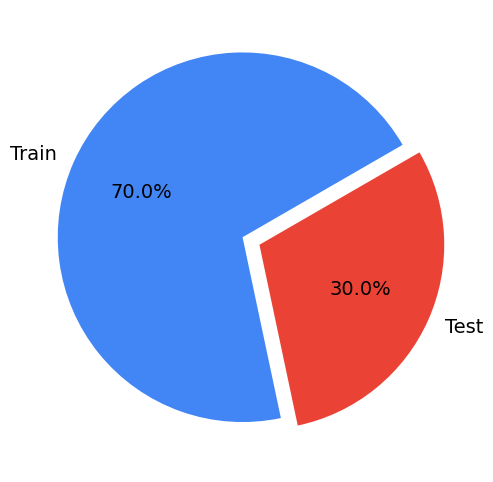

In [8]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(y_train), len(y_test)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0.05),
        startangle=30);

In [9]:
from transformers import TFAutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
inputs = tokenizer(X_train.tolist(), padding = True, truncation = True, return_tensors = 'tf')
inputs

import tensorflow as tf

output = tf.convert_to_tensor(y_train, dtype=tf.int64)
output

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
segment_ids = inputs.get("token_type_ids", None)

# Step 3: Convert to TensorFlow tensors
input_ids = tf.convert_to_tensor(input_ids)
attention_mask = tf.convert_to_tensor(attention_mask)
segment_ids = tf.convert_to_tensor(segment_ids) if segment_ids is not None else None


# Step 5: Create a dictionary of input tensors
input_dict = {
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "token_type_ids": segment_ids  # Include this if your BERT model expects segment_ids
}
inputstest = tokenizer(X_test.tolist(), padding = True, truncation = True, return_tensors = 'tf')


input_idstest = inputstest["input_ids"]
attention_masktest = inputstest["attention_mask"]
segment_idstest = inputstest.get("token_type_ids", None)

# Step 3: Convert to TensorFlow tensors
input_idstest = tf.convert_to_tensor(input_idstest)
attention_masktest = tf.convert_to_tensor(attention_masktest)
segment_idstest = tf.convert_to_tensor(segment_idstest) if segment_idstest is not None else None


# Step 5: Create a dictionary of input tensors
input_dicttest = {
    "input_ids": input_idstest,
    "attention_mask": attention_masktest,
    "token_type_ids": segment_idstest  # Include this if your BERT model expects segment_ids
}


outputtest = tf.convert_to_tensor(y_test, dtype=tf.int64)
outputtest

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<tf.Tensor: shape=(5501,), dtype=int64, numpy=array([2, 1, 2, ..., 1, 2, 1])>

##### 4)Model Architecture

In [10]:
class BERTForClassification(tf.keras.Model):
  def __init__(self, bert_model, num_classes):
      super().__init__()
      self.bert = bert_model
      self.fc = tf.keras.layers.Dense(num_classes, activation = "softmax")
  def call(self, inputs):
    x = self.bert(inputs)[1]
    return self.fc(x)


model = TFAutoModel.from_pretrained("bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
classifier = BERTForClassification(model, num_classes = 3)
classifier.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

##### 5) Training Model

In [12]:
history  = classifier.fit(input_dict, output, epochs = 5, validation_data=(input_dicttest, outputtest))

Epoch 1/5
401/401 [==============================] - 167s 306ms/step - loss: 0.4842 - accuracy: 0.8005 - val_loss: 0.5579 - val_accuracy: 0.7719
Epoch 2/5
401/401 [==============================] - 121s 301ms/step - loss: 0.3123 - accuracy: 0.8765 - val_loss: 0.5531 - val_accuracy: 0.7759
Epoch 3/5
401/401 [==============================] - 122s 304ms/step - loss: 0.2312 - accuracy: 0.9132 - val_loss: 0.5904 - val_accuracy: 0.7899
Epoch 4/5
401/401 [==============================] - 122s 305ms/step - loss: 0.1586 - accuracy: 0.9432 - val_loss: 0.6572 - val_accuracy: 0.7757
Epoch 5/5
401/401 [==============================] - 114s 283ms/step - loss: 0.1054 - accuracy: 0.9645 - val_loss: 0.7591 - val_accuracy: 0.7782


##### 6) Finding Training and Testing Accuracy

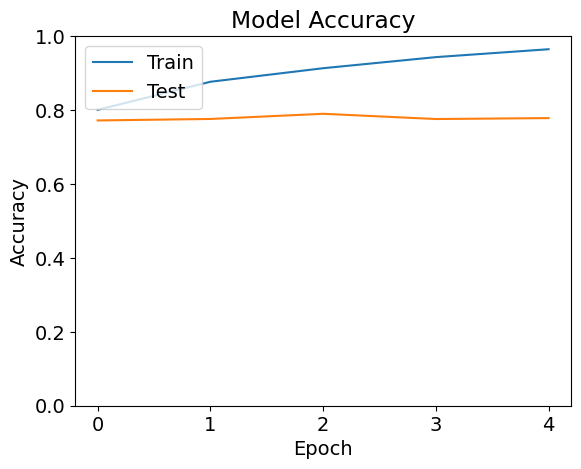

In [13]:
# Plot the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
test_loss,test_acc=classifier.evaluate(input_dicttest,outputtest)
test_loss,test_acc

172/172 [==============================] - 13s 76ms/step - loss: 0.7591 - accuracy: 0.7782


(0.7591336369514465, 0.7782221436500549)

##### 7) Compute and plot the confusion matrix for the three classes

In [19]:
predictions=classifier.predict(input_dicttest)
class_labels = ['negative', 'positive','neutral']
predicted_class_labels = [class_labels[np.argmax(pred)] for pred in predictions]
actual_class_labels=[class_labels[actual] for actual in y_test]
print(classification_report(actual_class_labels, predicted_class_labels))

172/172 [==============================] - 18s 76ms/step
              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      3447
     neutral       0.58      0.61      0.60      1154
    positive       0.70      0.72      0.71       900

    accuracy                           0.78      5501
   macro avg       0.72      0.73      0.72      5501
weighted avg       0.78      0.78      0.78      5501



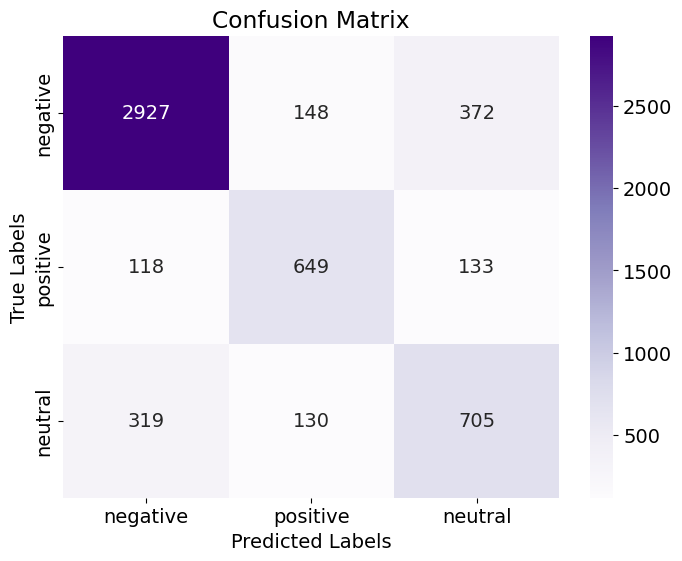

In [20]:
conf_matrix = confusion_matrix(actual_class_labels, predicted_class_labels, labels=class_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

##### 8) Saving the final results in Excel sheet

In [21]:
precision_per_class = precision_score(actual_class_labels, predicted_class_labels, average=None)
recall_per_class = recall_score(actual_class_labels, predicted_class_labels, average=None)

print("Precision per class:", precision_per_class)
print("Recall per class:", recall_per_class)

Precision per class: [0.87009512 0.58264463 0.70010787]
Recall per class: [0.84914418 0.61091854 0.72111111]


In [22]:
f1_micro = f1_score(actual_class_labels, predicted_class_labels, average='micro')
f1_macro = f1_score(actual_class_labels, predicted_class_labels, average='macro')

print("Micro F1 Score:", f1_micro)
print("Macro F1 Score:", f1_macro)

Micro F1 Score: 0.7782221414288311
Macro F1 Score: 0.7221309984689839


In [24]:
result=pd.read_csv('BERT_ModelResults.csv')
result['GPT3.5_Dataset']=[max(history.history['accuracy']),test_acc,f1_micro,f1_macro,precision_per_class[0],precision_per_class[1],precision_per_class[2],recall_per_class[0],recall_per_class[1],recall_per_class[2]]
result[['Unnamed: 0','GPT3.5_Dataset']]

,Unnamed: 0,GPT3.5_Dataset
0,Training Accuracy,0.964536
1,Testing Accuracy,0.778222
2,Micro F1 Score,0.778222
3,Macro F1 Score,0.722131
4,Precision for Negative sentiment,0.870095
5,Precision for Positive sentiment,0.582645
6,Precision for Neutral sentiment,0.700108
7,Recall for Negative sentiment,0.849144
8,Recall for Positive sentiment,0.610919
9,Recall for Neutral sentiment,0.721111


In [26]:
result.to_csv('BERT_ModelResults.csv', index=False)